This notebook contains scripts to instantiate and run the entraining plume model. The code has been tested on ARM site observations from Nauru and CACTI. <br>
The user can specify the ARM site, custom preprocessing script, launch level, and choose between simple microphysics schemes.<br>
This script also contains example analyses of the plume model output. <br>

<b> Note: </b>If you change the input data, you will likely have to specify your own preprocessor to hand off temperature, humidity, level and time information to the plume model wrapper (see PlumeModel class in PlumeModel.py).



In [1]:
import importlib
import PlumeModel
from preprocessors import preprocess_ARMBE, preprocess_Nauru
importlib.reload(PlumeModel)
import time
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
input_dir = Path('/neelin2020/ARM/CACTI/')
fil_interpsonde = [str(i) for i in (input_dir/'interpsonde').glob('*.nc')]
fil_interpsonde.sort()
fil_interpsonde

['/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180928.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180929.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20180930.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181001.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181002.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181003.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181004.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181005.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181006.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181007.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181008.000030.nc',
 '/neelin2020/ARM/CACTI/interpsonde/corinterpolatedsondeM1.c1.20181009.000030.nc',
 '/n

In [5]:
import xarray as xr
def preprocess_interpsonde_CACTI(fils):
    ds = xr.open_mfdataset(fils)
    return ds

ds = preprocess_interpsonde_CACTI(fil_interpsonde)


In [25]:
import pandas as pd
time_series = pd.date_range(start=ds.time[0].values, end=ds.time[-1].values, freq='0.25H')
ds.sel(time=time_series, method='nearest').sel(height=slice(0, 15))

<xarray.Dataset>
Dimensions:            (time: 20736, height: 208)
Coordinates:
  * time               (time) datetime64[ns] 2018-09-28T00:00:30 ... 2019-05-...
  * height             (height) float32 1.141 1.161 1.181 ... 14.4 14.6 14.8
Data variables: (12/39)
    base_time          (time) datetime64[ns] 2018-09-28 ... 2019-05-01
    time_offset        (time) datetime64[ns] dask.array<chunksize=(96,), meta=np.ndarray>
    precip             (time) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    qc_precip          (time) int32 dask.array<chunksize=(96,), meta=np.ndarray>
    temp               (time, height) float32 dask.array<chunksize=(96, 208), meta=np.ndarray>
    qc_temp            (time, height) int32 dask.array<chunksize=(96, 208), meta=np.ndarray>
    ...                 ...
    qc_rh_scaled       (time, height) int32 dask.array<chunksize=(96, 208), meta=np.ndarray>
    aqc_rh_scaled      (time, height) int32 dask.array<chunksize=(96, 208), meta=np.ndarray>
    vapor_source       (time, height) int32 dask.array<chunksize=(96, 208), meta=np.ndarray>
    lat                (time) float32 -32.13 -32.13 -32.13 ... -32.13 -32.13
    lon                (time) float32 -64.73 -64.73 -64.73 ... -64.73 -64.73
    alt                (time) float32 1.141e+03 1.141e+03 ... 1.141e+03
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s cor -f M1 -DR ...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     corgriddedsondeM1.c0 : 3.0 : 20180928.000030-20180...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               cor
    ...                    ...
    facility_id:           M1
    data_level:            c1
    location_description:  Cloud, Aerosol, and Complex Terrain Interactions (...
    datastream:            corinterpolatedsondeM1.c1
    doi:                   10.5439/1095316
    history:               created by user dsmgr on machine ruby at 2019-04-1...

In [28]:
import numpy as np
heights = np.arange(0, 15.5, 0.5)
heights.size

31

In [ ]:
ds.temp

In [14]:
site = 'CACTI'
output_dir = './'  # directory to save the output files

if site == 'Nauru':

    output_file_name = 'plume_props_Nauru'  # name of the output file
    input_dir = '/neelin2020/ARM/ARM_Nauru/'
    fils = [str(i) for i in Path(input_dir).glob('ARM_NAURU_Tq*.nc')]  # look for all .nc files in the directory
    preprocess = preprocess_Nauru

elif site == 'CACTI':

    output_file_name = 'plume_props_CACTI'  # name of the output file
    input_dir = '/neelin2020/ARM/CACTI/'
    fils = [str(i) for i in Path(input_dir).glob('corarmbeatm*.nc')]  # look for all .nc files in the directory
    preprocess = preprocess_ARMBE


pm = PlumeModel.PlumeModel(fils = fils,
                           preprocess = preprocess,
                           output_file_name = output_file_name, 
                           output_dir = output_dir, 
                           launch_opt = 'specified',  # specified level or from the surface
                           launch_level = 700,        # launch level in hPa
                           rain_out = 0.0,            # rain out threshold (kg/kg)
                           microphysics = 2,          # 1: No supersaturation; freeze all liquid at 0C, 2: mixed-phase region allowed
                           DIB_mix_upper = 450,       # upper level for DIB mixing; no mixing above this level
                           mix_opt = 'DIB',           # mixing option: 'DIB' or 'NOMIX'
                           C0 = 0.2,)                 # Autoconversion threshold for condensate->rain conversion

In [15]:
pm.preprocess_data()
pm.mixing_coefficients()

In [16]:
stime = time.time()
pm.run_plume(mix = pm.mix_opt)
print(f'Done. Took {time.time()-stime: .3f} seconds')

RUNNING DIB PLUME COMPUTATION
Done. Took  0.574 seconds


In [17]:
pm.postprocess_save()

SAVING FILE
File saved as /home/fiaz/plume_model/plume_props_CACTI.nc


/home/fiaz/plume_model/thermodynamic_functions.py:272: RuntimeWarning: invalid value encountered in log
  TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
/home/fiaz/plume_model/thermodynamic_functions.py:279: RuntimeWarning: invalid value encountered in power
  theta_e = temp * pow((pref / press), chi_e) * np.exp( ALV * r / ((CPD + rt * CL) * temp)) * pow(H, -r * RV/ (CPD + (rt * CL)))


## Analyze saved output

In [18]:
import xarray as xr
fil_out = pm.output_file_name.with_suffix('.nc')
ds = xr.open_dataset(fil_out)

### Plot buoyancy time series and example $\theta_e$ of the plume and environment

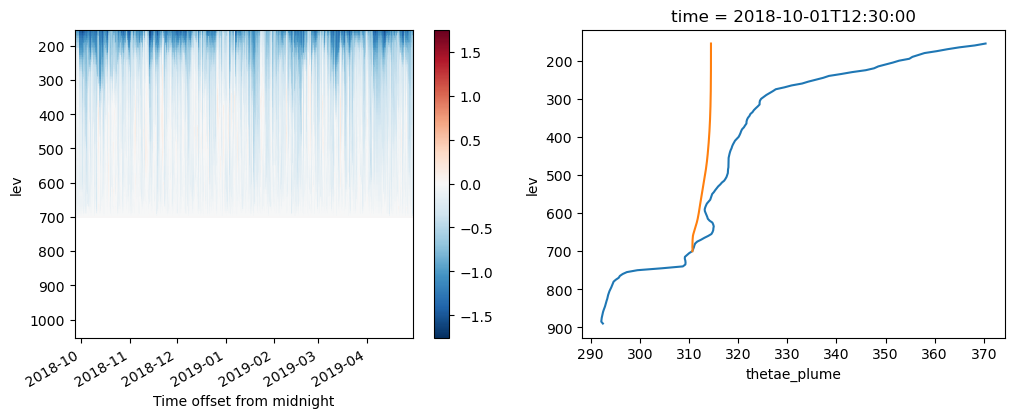

In [19]:
fig, axx = plt.subplots(1, 2, figsize = (12, 4))
buoy = 9.8 * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
buoy.plot(y = 'lev', yincrease = False, ax = axx[0])

tidx = 2
ds.thetae_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = axx[1])
ds.thetae_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = axx[1])


In [21]:
# Layer averaged buoyancy and precipitation
from scipy.io import loadmat
fil_nauru = '/neelin2020/ARM/ARM_Nauru/precip_nauru_1hravg_matchedtosondes_Apr2001_Aug2006.mat'

def compute_layer_ave_buoy(ds, pstrt = 800, pend = 400):
    """
    Use the virtual temperature to compute 
    layer-averaged buoyancy
    """
    g = 9.8
    buoy = g * (ds.Tv_plume - ds.Tv_env)/ds.Tv_env
    buoy_slice = buoy.sel(lev = slice(pstrt, pend)).dropna('lev')
    layer_depth = buoy_slice.lev.isel(lev = 0) - buoy_slice.lev.isel(lev = -1) 
    return -buoy_slice.integrate('lev')/(layer_depth)
 

def open_files_include_precip(ds, fils, site):
    buoy_lft = compute_layer_ave_buoy(ds)

    if site == 'CACTI':
        ds_prc = xr.open_mfdataset(fils)
        ds_prc = ds_prc.where(ds_prc.time.isin(buoy_lft.time), drop = True)
        prc = ds_prc.precip_rate_sfc
        prc = prc.where(prc.time.isin(buoy_lft.time), drop = True)
        ds['precip'] = prc

    elif site == 'NAURU':
        data = loadmat(fil_nauru)
        precip = data['precmeancholloworig']
        ds['precip'] = (('time'), precip.squeeze())

    return ds, buoy_lft

# compute LFT buoy
ds, buoy_lft = open_files_include_precip(ds, fils, site)

## Precipitation-buoyancy statistics 

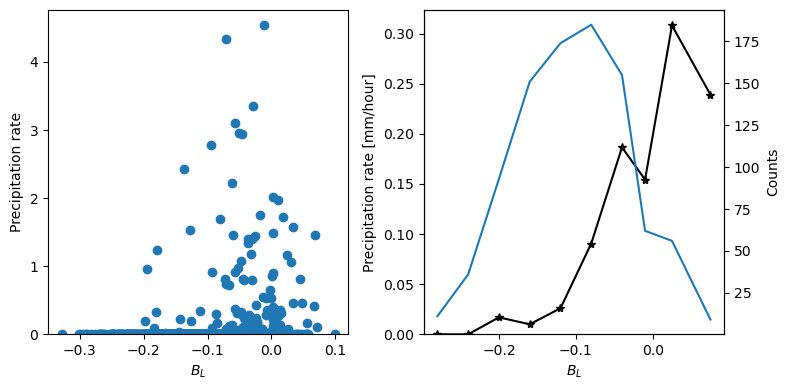

In [23]:
import numpy as np
buoy_bins = np.arange(-0.3, 0.0, 0.04)
buoy_bins = np.append(buoy_bins, (np.arange(0, 0.25, 0.05)))

fig, axx = plt.subplots(1, 2, figsize = (8, 4))
ax = axx[0]
ax.scatter(buoy_lft, ds.precip)

ax.set_ylim(bottom = 0)
ax.set_ylabel('Precipitation rate')
ax.set_xlabel('$B_L$')

ax = axx[1]
ax2 = ax.twinx()
ds.precip.groupby_bins(buoy_lft, bins = buoy_bins).count().plot(ax = ax2)
ds.precip.groupby_bins(buoy_lft, bins = buoy_bins).mean().plot(ax = ax, c = 'black', marker = '*')

ax.set_ylim(bottom = 0)
ax2.set_ylabel('Counts')
ax.set_xlabel('$B_L$')
plt.tight_layout()


## Example hydrometeor information<br>
Note: if the freezing level is below the LCL, the plume liquid water may not contain any liquid water

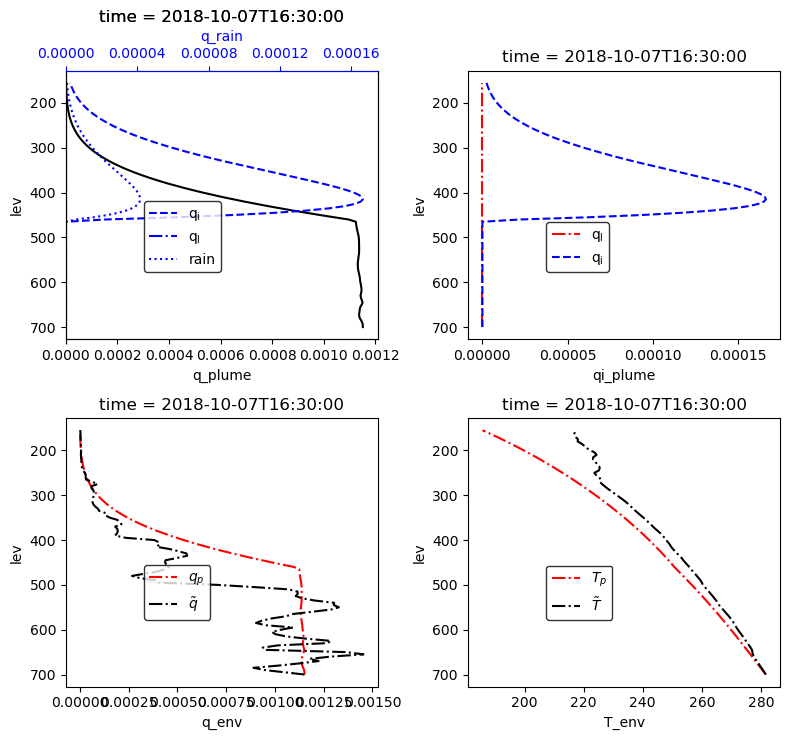

In [24]:
g = 9.8 
fig, axx = plt.subplots(2, 2, figsize = (8, 7.5))
tidx = 28

ax = axx[0,0]
ax2 = ax.twiny()
ds.q_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, color = 'black')
ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = '-.', label = '$\mathrm{q_l}$')
ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax2, c = 'blue', linestyle = ':', label = 'rain')

ax2.spines['top'].set_color('blue') 
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue')
ax.set_xlim(left = 0)
ax2.set_xlim(left = 0)
leg = ax2.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')
# set major locator
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

ax = axx[0,1]
ds.ql_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$\mathrm{q_l}$')
ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

ax = axx[1,0]
ds.q_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$q_p$')
ds.q_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'black', linestyle = '-.', label = '$\\tilde{q}$')

# ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

ax = axx[1,1]
ds.T_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'red', linestyle = '-.', label = '$T_p$')
ds.T_env.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'black', linestyle = '-.', label = '$\\tilde{T}$')

# ds.qi_plume.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = '--', label = '$\mathrm{q_i}$')
leg = ax.legend(loc = (0.25, 0.25))
leg.get_frame().set_edgecolor('black')

# ds.q_rain.isel(time = tidx).plot(y = 'lev', yincrease = False, ax = ax, c = 'blue', linestyle = ':', label = 'rain')


plt.tight_layout()

Thermal or Archimedean Buoyancy: $ B = g \frac{T_{vp} - \bar{T}_v}{\bar{T}_v}$<br>
$B_L = \frac{1}{\Delta p_L}\int^{500}_{800} B dp$<br>
$T_v = T(1 + \epsilon q_v - q_c)$ <br>
$\theta_e = f(T,q,p)$

### Plume buoyancy conditionally averaged by $\mathrm{B_L}$

/tmp/ipykernel_197496/1662975625.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm),


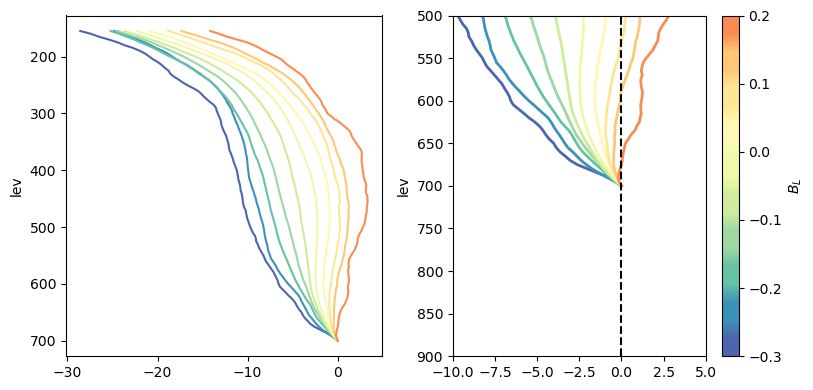

In [26]:
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib import ticker

fig, axx = plt.subplots(1, 2, figsize = (8, 4))

ax = axx[0]
DeltaTv = (ds.Tv_plume - ds.Tv_env).groupby_bins(buoy_lft, bins = buoy_bins)
cmap = plt.colormaps['Spectral_r']
norm = Normalize(vmin = buoy_bins[0], vmax = buoy_bins[-1])
cm_list = []
for i, (key, group) in enumerate(DeltaTv):
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = ax, label = key, color = cmap(norm(key.mid)))
    
    group.mean('time').plot(y = 'lev', yincrease = False, 
                            ax = axx[1], label = key, linewidth = 2.,
                            color = cmap(norm(key.mid)))
    cm_list.append(cmap(norm(key.mid)))
    
    cm_list.append(cmap(norm(key.mid)))

cm = LinearSegmentedColormap.from_list('defcol', cm_list)

axx[1].set_ylim(900,500)
axx[1].set_xlim(-10, 5)
axx[1].vlines(0, 900, 500, linestyle = '--', color = 'black')
plt.tight_layout()

cb = plt.colorbar(ScalarMappable(cmap = cm, norm = norm), 
             ticks = buoy_bins[::4], label='$B_L$')
cb.ax.yaxis.set_major_locator(ticker.AutoLocator())


### EOF analysis on buoyancy profiles

(-1.0, 10.0)

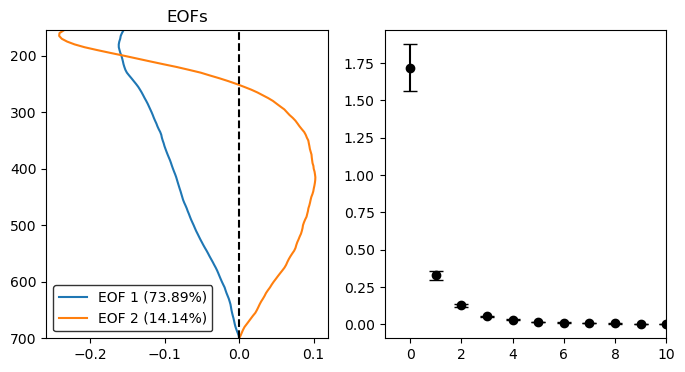

In [108]:
import numpy as np
# buoy_anom = (buoy - buoy.mean('time')).dropna('lev')
buoy_anom = (buoy - buoy.mean('time')).dropna('lev', how = 'all').dropna('time')
eig, vec = np.linalg.eig(np.cov(buoy_anom.T))

fig, axx = plt.subplots(1, 2, figsize = (8, 4))
ax = axx[0]
ax.plot(vec[:, 0], buoy_anom.lev, label = f'EOF 1 ({eig[0]*100/eig.sum():.2f}%)' )
ax.plot(vec[:, 1], buoy_anom.lev, label = f'EOF 2 ({eig[1]*100/eig.sum():.2f}%)')

ax.set_ylim(buoy_anom.lev[0], buoy_anom.lev[-1])
ax.set_title('EOFs', fontsize = 12)
leg = ax.legend(loc = 'lower left')
leg.get_frame().set_edgecolor('black')
ax.vlines(0, buoy_anom.lev[0], buoy_anom.lev[-1], linestyle = '--', color = 'black')

ax = axx[1]
N = buoy_anom.time.size
# ax.scatter(range(eig.size), eig)
ax.errorbar(range(eig.size), eig, yerr = 1.96 * eig * np.sqrt(2/N), fmt = 'o', capsize=5,
color = 'black')
ax.set_xlim(-1,10)
